In [1]:
import pandas as pd
from pandas import Series
from datetime import datetime
import numpy as np
import netCDF4
from netCDF4 import Dataset
import xlsxwriter
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import glob
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [2]:
ec_data = pd.read_excel(r'C:\Users\soura\OneDrive\Desktop\gapfilling_using_machine_learning\2023_data.xlsx')
# ec_data['Date'] = pd.to_datetime(ec_data['Date'])
# ec_data.set_index('Date', inplace=True)

In [3]:
ec_data_copy = ec_data.copy()
#corr_data = ec_data_copy.dropna()
#corr_data.isnull().sum()
ec_data_copy.isnull().sum()

Date                                                      0
NEE (CO2)                                                 0
GPP                                                       0
Ecosystem Respiration                                     0
Mean Air Temperature                                      0
Minimum Air Temperature                                   0
Maximum Air Temperature                                   0
Total Rainfall                                            0
Mean Soil Temperature (4 cm)                             31
Minimum Soil Temperature (4 cm)                          29
Maximum Soil Temperature (4 cm)                          29
Total Incoming shortwave radiaiton (global radiaiton)     0
Mean Relative Humidity                                   33
Mean PPFD                                                70
Mean Wind Speed                                           0
Vapour Pressure deficit                                   0
Net Radiation                           

C:\Users\soura\AppData\Local\Temp\ipykernel_7920\1040375050.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_data[col] = pd.to_numeric(corr_data[col], errors='coerce')


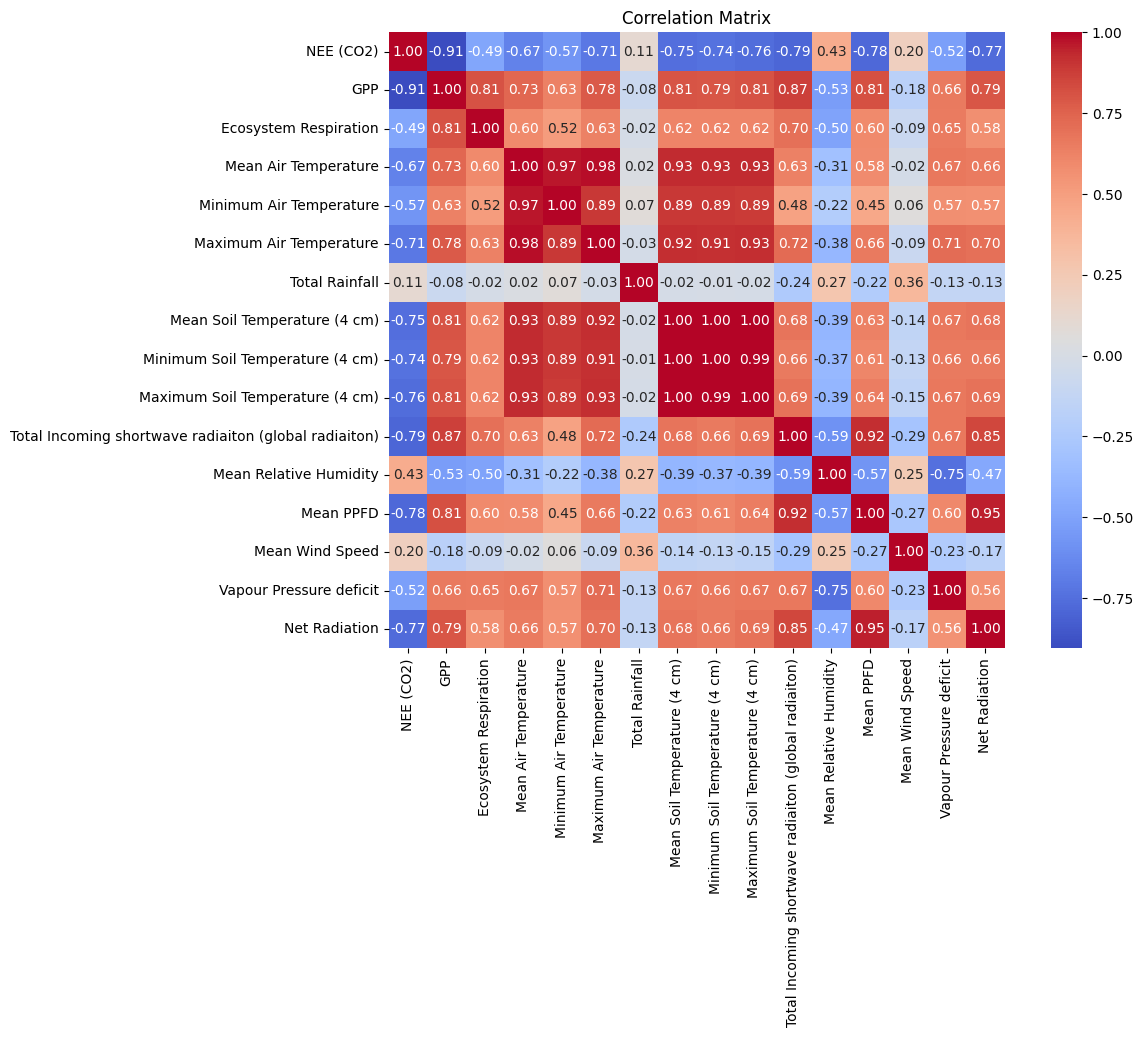

In [4]:
# Calculating correlation matrix
ec_data_copy = ec_data.copy()
corr_data = ec_data_copy.dropna()
# Step 1: Identify object type columns
object_columns = corr_data.select_dtypes(include=['object']).columns

# Step 2: Convert these columns to float
for col in object_columns:
    corr_data[col] = pd.to_numeric(corr_data[col], errors='coerce')
    
corr_data = corr_data[['NEE (CO2)', 'GPP', 'Ecosystem Respiration', 'Mean Air Temperature', 'Minimum Air Temperature', 'Maximum Air Temperature', 
                            'Total Rainfall', 'Mean Soil Temperature (4 cm)', 'Minimum Soil Temperature (4 cm)', 'Maximum Soil Temperature (4 cm)', 
                            'Total Incoming shortwave radiaiton (global radiaiton)', 'Mean Relative Humidity', 'Mean PPFD', 'Mean Wind Speed', 
                            'Vapour Pressure deficit', 'Net Radiation']]
correlation_matrix = corr_data.corr()

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title("Correlation Matrix")
plt.show()


In [5]:
print(ec_data_copy.columns.tolist())

['Date', 'NEE (CO2)', 'GPP', 'Ecosystem Respiration', 'Mean Air Temperature', 'Minimum Air Temperature', 'Maximum Air Temperature', 'Total Rainfall', 'Mean Soil Temperature (4 cm)', 'Minimum Soil Temperature (4 cm)', 'Maximum Soil Temperature (4 cm)', 'Total Incoming shortwave radiaiton (global radiaiton)', 'Mean Relative Humidity', 'Mean PPFD', 'Mean Wind Speed', 'Vapour Pressure deficit', 'Net Radiation']


Random Forest R^2: 0.9847278652513329
SVM R^2: 0.864491562015308
Linear Regression R^2: 0.849843821066901
HistGradientBoosting R^2: 0.9701535742050402
Best model: RandomForestRegressor(random_state=42)


C:\Users\soura\AppData\Local\Temp\ipykernel_7920\969142.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_soil.loc[missing_pe, 'Mean Soil Temperature (4 cm)'] = predicted_pe


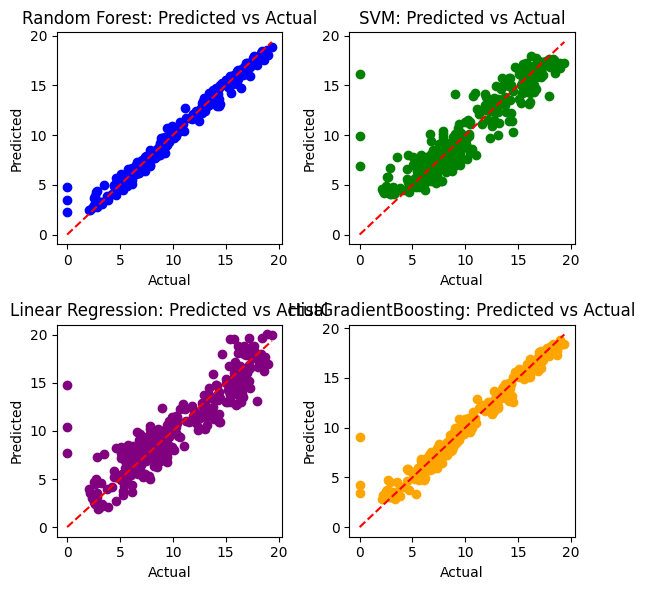

In [6]:
mean_soil = ec_data_copy[['NEE (CO2)', 'GPP', 'Ecosystem Respiration', 'Mean Air Temperature', 'Minimum Air Temperature', 'Maximum Air Temperature', 
                            'Mean Soil Temperature (4 cm)']]

# Step 1: Identify the rows where 'Mean Soil Temperature (4 cm)' is missing
missing_pe = mean_soil['Mean Soil Temperature (4 cm)'].isna()

# Step 2: Prepare data for training (only use rows where 'Mean Soil Temperature (4 cm)' is not missing)
train_data = mean_soil[~missing_pe]
X_train = train_data.drop(columns=['Mean Soil Temperature (4 cm)'])    # Features
y_train = train_data['Mean Soil Temperature (4 cm)']  # Target

# Step 3: Handle missing values (imputation)
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or other strategies
X_train_imputed = imputer.fit_transform(X_train)

# Step 4: Select the best model (Random Forest, SVM, or Linear Regression)
# Initialize the models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
svm_model = SVR(kernel='rbf')
lr_model = LinearRegression()
hgb_model = HistGradientBoostingRegressor()

# Train the models
rf_model.fit(X_train_imputed, y_train)
svm_model.fit(X_train_imputed, y_train)
lr_model.fit(X_train_imputed, y_train)
hgb_model.fit(X_train_imputed, y_train)

# Step 5: Evaluate the models and choose the best one (based on R^2 score, for example)
rf_score = rf_model.score(X_train_imputed, y_train)
svm_score = svm_model.score(X_train_imputed, y_train)
lr_score = lr_model.score(X_train_imputed, y_train)
hgb_score = hgb_model.score(X_train_imputed, y_train)

# Print the scores
print(f"Random Forest R^2: {rf_score}")
print(f"SVM R^2: {svm_score}")
print(f"Linear Regression R^2: {lr_score}")
print(f"HistGradientBoosting R^2: {hgb_score}")

# Choose the model with the highest R^2 score
best_model = None
best_score = -np.inf

if rf_score > best_score:
    best_model = rf_model
    best_score = rf_score
elif svm_score > best_score:
    best_model = svm_model
    best_score = svm_score
elif lr_score > best_score:
    best_model = lr_model
    best_score = lr_score
else:
    best_model = hgb_model
    best_score = hgb_score

print(f"Best model: {best_model}")

# Step 6: Use the best model to predict the missing 'Mean Soil Temperature (4 cm)' values
# Impute the missing rows
X_missing = mean_soil[missing_pe].drop(columns=['Mean Soil Temperature (4 cm)'])  # Features for missing 'Mean Soil Temperature (4 cm)' rows
X_missing_imputed = imputer.transform(X_missing)  # Apply the same imputation transformation

# Predict missing 'Mean Soil Temperature (4 cm)' values
predicted_pe = best_model.predict(X_missing_imputed)

# Step 7: Fill the missing 'Mean Soil Temperature (4 cm)' values with the predictions
mean_soil.loc[missing_pe, 'Mean Soil Temperature (4 cm)'] = predicted_pe

# Step 8: Plot graphs to compare the models' performance

# Make predictions with all models for comparison
rf_pred = rf_model.predict(X_train_imputed)
svm_pred = svm_model.predict(X_train_imputed)
lr_pred = lr_model.predict(X_train_imputed)
hgb_pred = hgb_model.predict(X_train_imputed)

# Plotting predicted vs actual for each model
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

# Random Forest
axs[0, 0].scatter(y_train, rf_pred, color='blue', label='Random Forest')
axs[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[0, 0].set_title('Random Forest: Predicted vs Actual')
axs[0, 0].set_xlabel('Actual')
axs[0, 0].set_ylabel('Predicted')

# SVM
axs[0, 1].scatter(y_train, svm_pred, color='green', label='SVM')
axs[0, 1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[0, 1].set_title('SVM: Predicted vs Actual')
axs[0, 1].set_xlabel('Actual')
axs[0, 1].set_ylabel('Predicted')

# Linear Regression
axs[1, 0].scatter(y_train, lr_pred, color='purple', label='Linear Regression')
axs[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[1, 0].set_title('Linear Regression: Predicted vs Actual')
axs[1, 0].set_xlabel('Actual')
axs[1, 0].set_ylabel('Predicted')

# HistGradientBoosting
axs[1, 1].scatter(y_train, hgb_pred, color='orange', label='HistGradientBoosting')
axs[1, 1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[1, 1].set_title('HistGradientBoosting: Predicted vs Actual')
axs[1, 1].set_xlabel('Actual')
axs[1, 1].set_ylabel('Predicted')

plt.tight_layout()
plt.show()

# creating pe data for merging to the original merged dataset
mst_data = mean_soil[['Mean Soil Temperature (4 cm)']]
mst_data = mst_data
mst_data1 = mst_data.rename(columns={'Mean Soil Temperature (4 cm)': 'mean_soil_t_4cm'})
merged_mean_soil_df = pd.merge(mean_soil, mst_data1, left_index=True, right_index=True)

In [7]:
print(ec_data_copy.columns.tolist())

['Date', 'NEE (CO2)', 'GPP', 'Ecosystem Respiration', 'Mean Air Temperature', 'Minimum Air Temperature', 'Maximum Air Temperature', 'Total Rainfall', 'Mean Soil Temperature (4 cm)', 'Minimum Soil Temperature (4 cm)', 'Maximum Soil Temperature (4 cm)', 'Total Incoming shortwave radiaiton (global radiaiton)', 'Mean Relative Humidity', 'Mean PPFD', 'Mean Wind Speed', 'Vapour Pressure deficit', 'Net Radiation']


Random Forest R^2: 0.9808988464305791
SVM R^2: 0.8230235906523717
Linear Regression R^2: 0.812629718083785
HistGradientBoosting R^2: 0.9682060853993334
Best model: RandomForestRegressor(random_state=42)


C:\Users\soura\AppData\Local\Temp\ipykernel_7920\1553731425.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_soil.loc[missing_pe, 'Minimum Soil Temperature (4 cm)'] = predicted_pe


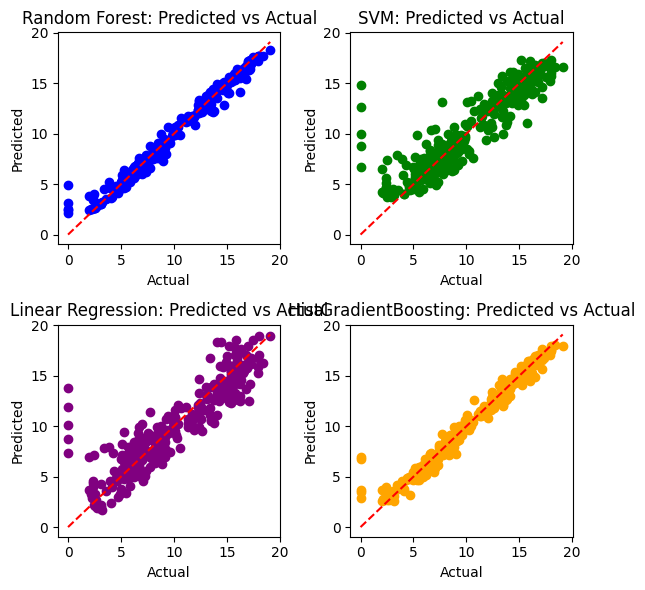

In [8]:
min_soil = ec_data_copy[['NEE (CO2)', 'GPP', 'Ecosystem Respiration', 'Mean Air Temperature', 'Minimum Air Temperature', 'Maximum Air Temperature', 
                             'Mean Soil Temperature (4 cm)']]

min_soil = ec_data_copy[['NEE (CO2)', 'GPP', 'Ecosystem Respiration', 'Mean Air Temperature', 'Minimum Air Temperature', 'Maximum Air Temperature', 
                            'Total Rainfall', 'Minimum Soil Temperature (4 cm)']]

# Step 1: Identify the rows where 'Minimum Soil Temperature (4 cm)' is missing
missing_pe = min_soil['Minimum Soil Temperature (4 cm)'].isna()

# Step 2: Prepare data for training (only use rows where 'Minimum Soil Temperature (4 cm)' is not missing)
train_data = min_soil[~missing_pe]
X_train = train_data.drop(columns=['Minimum Soil Temperature (4 cm)'])    # Features
y_train = train_data['Minimum Soil Temperature (4 cm)']  # Target

# Step 3: Handle missing values (imputation)
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or other strategies
X_train_imputed = imputer.fit_transform(X_train)

# Step 4: Select the best model (Random Forest, SVM, or Linear Regression)
# Initialize the models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
svm_model = SVR(kernel='rbf')
lr_model = LinearRegression()
hgb_model = HistGradientBoostingRegressor()

# Train the models
rf_model.fit(X_train_imputed, y_train)
svm_model.fit(X_train_imputed, y_train)
lr_model.fit(X_train_imputed, y_train)
hgb_model.fit(X_train_imputed, y_train)

# Step 5: Evaluate the models and choose the best one (based on R^2 score, for example)
rf_score = rf_model.score(X_train_imputed, y_train)
svm_score = svm_model.score(X_train_imputed, y_train)
lr_score = lr_model.score(X_train_imputed, y_train)
hgb_score = hgb_model.score(X_train_imputed, y_train)

# Print the scores
print(f"Random Forest R^2: {rf_score}")
print(f"SVM R^2: {svm_score}")
print(f"Linear Regression R^2: {lr_score}")
print(f"HistGradientBoosting R^2: {hgb_score}")

# Choose the model with the highest R^2 score
best_model = None
best_score = -np.inf

if rf_score > best_score:
    best_model = rf_model
    best_score = rf_score
elif svm_score > best_score:
    best_model = svm_model
    best_score = svm_score
elif lr_score > best_score:
    best_model = lr_model
    best_score = lr_score
else:
    best_model = hgb_model
    best_score = hgb_score

print(f"Best model: {best_model}")

# Step 6: Use the best model to predict the missing 'Minimum Soil Temperature (4 cm)' values
# Impute the missing rows
X_missing = min_soil[missing_pe].drop(columns=['Minimum Soil Temperature (4 cm)'])  # Features for missing 'Minimum Soil Temperature (4 cm)' rows
X_missing_imputed = imputer.transform(X_missing)  # Apply the same imputation transformation

# Predict missing 'Minimum Soil Temperature (4 cm)' values
predicted_pe = best_model.predict(X_missing_imputed)

# Step 7: Fill the missing 'Minimum Soil Temperature (4 cm)' values with the predictions
min_soil.loc[missing_pe, 'Minimum Soil Temperature (4 cm)'] = predicted_pe

# Step 8: Plot graphs to compare the models' performance

# Make predictions with all models for comparison
rf_pred = rf_model.predict(X_train_imputed)
svm_pred = svm_model.predict(X_train_imputed)
lr_pred = lr_model.predict(X_train_imputed)
hgb_pred = hgb_model.predict(X_train_imputed)

# Plotting predicted vs actual for each model
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

# Random Forest
axs[0, 0].scatter(y_train, rf_pred, color='blue', label='Random Forest')
axs[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[0, 0].set_title('Random Forest: Predicted vs Actual')
axs[0, 0].set_xlabel('Actual')
axs[0, 0].set_ylabel('Predicted')

# SVM
axs[0, 1].scatter(y_train, svm_pred, color='green', label='SVM')
axs[0, 1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[0, 1].set_title('SVM: Predicted vs Actual')
axs[0, 1].set_xlabel('Actual')
axs[0, 1].set_ylabel('Predicted')

# Linear Regression
axs[1, 0].scatter(y_train, lr_pred, color='purple', label='Linear Regression')
axs[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[1, 0].set_title('Linear Regression: Predicted vs Actual')
axs[1, 0].set_xlabel('Actual')
axs[1, 0].set_ylabel('Predicted')

# HistGradientBoosting
axs[1, 1].scatter(y_train, hgb_pred, color='orange', label='HistGradientBoosting')
axs[1, 1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[1, 1].set_title('HistGradientBoosting: Predicted vs Actual')
axs[1, 1].set_xlabel('Actual')
axs[1, 1].set_ylabel('Predicted')

plt.tight_layout()
plt.show()

# creating pe data for merging to the original merged dataset
mst_data = min_soil[['Minimum Soil Temperature (4 cm)']]
mst_data = mst_data
mst_data2 = mst_data.rename(columns={'Minimum Soil Temperature (4 cm)': 'min_soil_t_4cm'})
merged_min_soil_df = pd.merge(min_soil, mst_data2, left_index=True, right_index=True)

Random Forest R^2: 0.9816042514901353
SVM R^2: 0.8341474890721532
Linear Regression R^2: 0.8203623501927158
HistGradientBoosting R^2: 0.9679571114690542
Best model: RandomForestRegressor(random_state=42)


C:\Users\soura\AppData\Local\Temp\ipykernel_7920\3605681521.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_soil.loc[missing_pe, 'Maximum Soil Temperature (4 cm)'] = predicted_pe


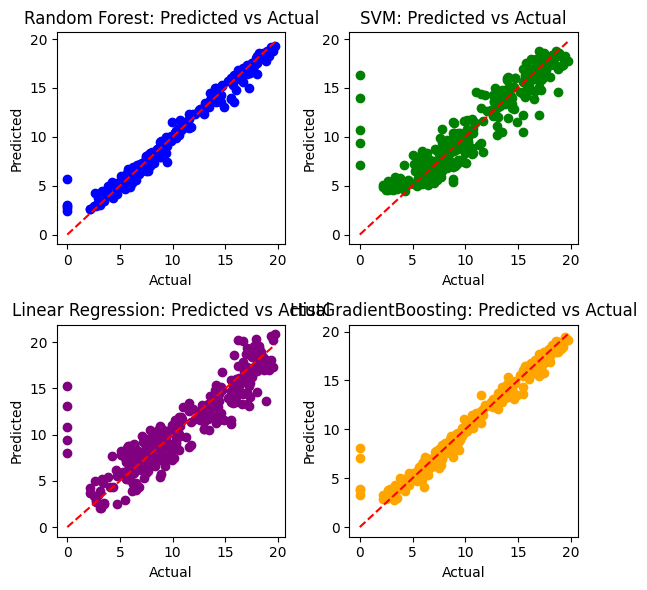

In [9]:
max_soil = ec_data_copy[['NEE (CO2)', 'GPP', 'Ecosystem Respiration', 'Mean Air Temperature', 'Minimum Air Temperature', 'Maximum Air Temperature', 
                            'Total Rainfall', 'Maximum Soil Temperature (4 cm)']]

# Step 1: Identify the rows where 'Maximum Soil Temperature (4 cm)' is missing
missing_pe = max_soil['Maximum Soil Temperature (4 cm)'].isna()

# Step 2: Prepare data for training (only use rows where 'Maximum Soil Temperature (4 cm)' is not missing)
train_data = max_soil[~missing_pe]
X_train = train_data.drop(columns=['Maximum Soil Temperature (4 cm)'])    # Features
y_train = train_data['Maximum Soil Temperature (4 cm)']  # Target

# Step 3: Handle missing values (imputation)
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or other strategies
X_train_imputed = imputer.fit_transform(X_train)

# Step 4: Select the best model (Random Forest, SVM, or Linear Regression)
# Initialize the models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
svm_model = SVR(kernel='rbf')
lr_model = LinearRegression()
hgb_model = HistGradientBoostingRegressor()

# Train the models
rf_model.fit(X_train_imputed, y_train)
svm_model.fit(X_train_imputed, y_train)
lr_model.fit(X_train_imputed, y_train)
hgb_model.fit(X_train_imputed, y_train)

# Step 5: Evaluate the models and choose the best one (based on R^2 score, for example)
rf_score = rf_model.score(X_train_imputed, y_train)
svm_score = svm_model.score(X_train_imputed, y_train)
lr_score = lr_model.score(X_train_imputed, y_train)
hgb_score = hgb_model.score(X_train_imputed, y_train)

# Print the scores
print(f"Random Forest R^2: {rf_score}")
print(f"SVM R^2: {svm_score}")
print(f"Linear Regression R^2: {lr_score}")
print(f"HistGradientBoosting R^2: {hgb_score}")

# Choose the model with the highest R^2 score
best_model = None
best_score = -np.inf

if rf_score > best_score:
    best_model = rf_model
    best_score = rf_score
elif svm_score > best_score:
    best_model = svm_model
    best_score = svm_score
elif lr_score > best_score:
    best_model = lr_model
    best_score = lr_score
else:
    best_model = hgb_model
    best_score = hgb_score

print(f"Best model: {best_model}")

# Step 6: Use the best model to predict the missing 'Maximum Soil Temperature (4 cm)' values
# Impute the missing rows
X_missing = max_soil[missing_pe].drop(columns=['Maximum Soil Temperature (4 cm)'])  # Features for missing 'Maximum Soil Temperature (4 cm)' rows
X_missing_imputed = imputer.transform(X_missing)  # Apply the same imputation transformation

# Predict missing 'Maximum Soil Temperature (4 cm)' values
predicted_pe = best_model.predict(X_missing_imputed)

# Step 7: Fill the missing 'Maximum Soil Temperature (4 cm)' values with the predictions
max_soil.loc[missing_pe, 'Maximum Soil Temperature (4 cm)'] = predicted_pe

# Step 8: Plot graphs to compare the models' performance

# Make predictions with all models for comparison
rf_pred = rf_model.predict(X_train_imputed)
svm_pred = svm_model.predict(X_train_imputed)
lr_pred = lr_model.predict(X_train_imputed)
hgb_pred = hgb_model.predict(X_train_imputed)

# Plotting predicted vs actual for each model
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

# Random Forest
axs[0, 0].scatter(y_train, rf_pred, color='blue', label='Random Forest')
axs[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[0, 0].set_title('Random Forest: Predicted vs Actual')
axs[0, 0].set_xlabel('Actual')
axs[0, 0].set_ylabel('Predicted')

# SVM
axs[0, 1].scatter(y_train, svm_pred, color='green', label='SVM')
axs[0, 1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[0, 1].set_title('SVM: Predicted vs Actual')
axs[0, 1].set_xlabel('Actual')
axs[0, 1].set_ylabel('Predicted')

# Linear Regression
axs[1, 0].scatter(y_train, lr_pred, color='purple', label='Linear Regression')
axs[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[1, 0].set_title('Linear Regression: Predicted vs Actual')
axs[1, 0].set_xlabel('Actual')
axs[1, 0].set_ylabel('Predicted')

# HistGradientBoosting
axs[1, 1].scatter(y_train, hgb_pred, color='orange', label='HistGradientBoosting')
axs[1, 1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[1, 1].set_title('HistGradientBoosting: Predicted vs Actual')
axs[1, 1].set_xlabel('Actual')
axs[1, 1].set_ylabel('Predicted')

plt.tight_layout()
plt.show()

# creating pe data for merging to the original merged dataset
mst_data = max_soil[['Maximum Soil Temperature (4 cm)']]
mst_data = mst_data
mst_data3 = mst_data.rename(columns={'Maximum Soil Temperature (4 cm)': 'max_soil_t_4cm'})
merged_max_soil_df = pd.merge(max_soil, mst_data3, left_index=True, right_index=True)

Random Forest R^2: 0.9591897948531924
SVM R^2: 0.45217643456832657
Linear Regression R^2: 0.5675375269488823
HistGradientBoosting R^2: 0.8710938710635567
Best model: RandomForestRegressor(random_state=42)


C:\Users\soura\AppData\Local\Temp\ipykernel_7920\75198800.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_rh.loc[missing_pe, 'Mean Relative Humidity'] = predicted_pe


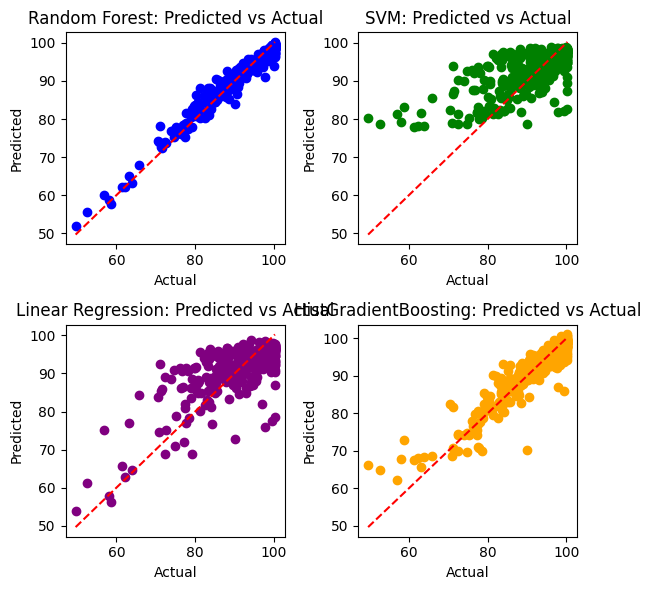

In [10]:
mean_rh = ec_data_copy[['NEE (CO2)', 'GPP', 'Ecosystem Respiration', 'Vapour Pressure deficit', 'Mean Relative Humidity']]

# Step 1: Identify the rows where 'Mean Relative Humidity' is missing
missing_pe = mean_rh['Mean Relative Humidity'].isna()

# Step 2: Prepare data for training (only use rows where 'Mean Relative Humidity' is not missing)
train_data = mean_rh[~missing_pe]
X_train = train_data.drop(columns=['Mean Relative Humidity'])    # Features
y_train = train_data['Mean Relative Humidity']  # Target

# Step 3: Handle missing values (imputation)
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or other strategies
X_train_imputed = imputer.fit_transform(X_train)

# Step 4: Select the best model (Random Forest, SVM, or Linear Regression)
# Initialize the models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
svm_model = SVR(kernel='rbf')
lr_model = LinearRegression()
hgb_model = HistGradientBoostingRegressor()

# Train the models
rf_model.fit(X_train_imputed, y_train)
svm_model.fit(X_train_imputed, y_train)
lr_model.fit(X_train_imputed, y_train)
hgb_model.fit(X_train_imputed, y_train)

# Step 5: Evaluate the models and choose the best one (based on R^2 score, for example)
rf_score = rf_model.score(X_train_imputed, y_train)
svm_score = svm_model.score(X_train_imputed, y_train)
lr_score = lr_model.score(X_train_imputed, y_train)
hgb_score = hgb_model.score(X_train_imputed, y_train)

# Print the scores
print(f"Random Forest R^2: {rf_score}")
print(f"SVM R^2: {svm_score}")
print(f"Linear Regression R^2: {lr_score}")
print(f"HistGradientBoosting R^2: {hgb_score}")

# Choose the model with the highest R^2 score
best_model = None
best_score = -np.inf

if rf_score > best_score:
    best_model = rf_model
    best_score = rf_score
elif svm_score > best_score:
    best_model = svm_model
    best_score = svm_score
elif lr_score > best_score:
    best_model = lr_model
    best_score = lr_score
else:
    best_model = hgb_model
    best_score = hgb_score

print(f"Best model: {best_model}")

# Step 6: Use the best model to predict the missing 'Mean Relative Humidity' values
# Impute the missing rows
X_missing = mean_rh[missing_pe].drop(columns=['Mean Relative Humidity'])  # Features for missing 'Mean Relative Humidity' rows
X_missing_imputed = imputer.transform(X_missing)  # Apply the same imputation transformation

# Predict missing 'Mean Relative Humidity' values
predicted_pe = best_model.predict(X_missing_imputed)

# Step 7: Fill the missing 'Mean Relative Humidity' values with the predictions
mean_rh.loc[missing_pe, 'Mean Relative Humidity'] = predicted_pe

# Step 8: Plot graphs to compare the models' performance

# Make predictions with all models for comparison
rf_pred = rf_model.predict(X_train_imputed)
svm_pred = svm_model.predict(X_train_imputed)
lr_pred = lr_model.predict(X_train_imputed)
hgb_pred = hgb_model.predict(X_train_imputed)

# Plotting predicted vs actual for each model
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

# Random Forest
axs[0, 0].scatter(y_train, rf_pred, color='blue', label='Random Forest')
axs[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[0, 0].set_title('Random Forest: Predicted vs Actual')
axs[0, 0].set_xlabel('Actual')
axs[0, 0].set_ylabel('Predicted')

# SVM
axs[0, 1].scatter(y_train, svm_pred, color='green', label='SVM')
axs[0, 1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[0, 1].set_title('SVM: Predicted vs Actual')
axs[0, 1].set_xlabel('Actual')
axs[0, 1].set_ylabel('Predicted')

# Linear Regression
axs[1, 0].scatter(y_train, lr_pred, color='purple', label='Linear Regression')
axs[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[1, 0].set_title('Linear Regression: Predicted vs Actual')
axs[1, 0].set_xlabel('Actual')
axs[1, 0].set_ylabel('Predicted')

# HistGradientBoosting
axs[1, 1].scatter(y_train, hgb_pred, color='orange', label='HistGradientBoosting')
axs[1, 1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[1, 1].set_title('HistGradientBoosting: Predicted vs Actual')
axs[1, 1].set_xlabel('Actual')
axs[1, 1].set_ylabel('Predicted')

plt.tight_layout()
plt.show()

# creating pe data for merging to the original merged dataset
mst_data = mean_rh[['Mean Relative Humidity']]
mst_data = mst_data
mst_data4 = mst_data.rename(columns={'Mean Relative Humidity': 'mean_rh_t_4cm'})
merged_mean_rh_df = pd.merge(mean_rh, mst_data4, left_index=True, right_index=True)

Random Forest R^2: 0.972114441391002
SVM R^2: 0.36931409444061203
Linear Regression R^2: 0.8127707161570965
HistGradientBoosting R^2: 0.9154320357577159
Best model: RandomForestRegressor(random_state=42)


C:\Users\soura\AppData\Local\Temp\ipykernel_7920\765862805.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_ppfd.loc[missing_pe, 'Mean PPFD'] = predicted_pe


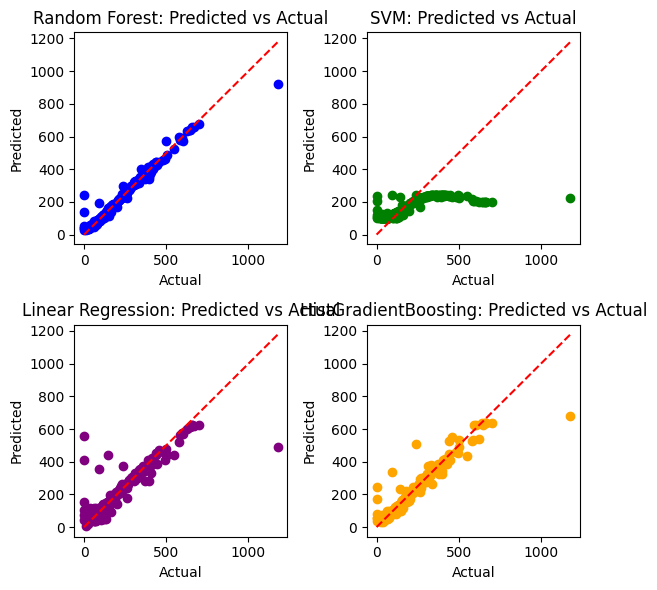

In [11]:
mean_ppfd = ec_data_copy[['NEE (CO2)', 'GPP', 'Ecosystem Respiration', 'Maximum Air Temperature', 'Total Incoming shortwave radiaiton (global radiaiton)',
                            'Mean PPFD']]

# Step 1: Identify the rows where 'Mean PPFD' is missing
missing_pe = mean_ppfd['Mean PPFD'].isna()

# Step 2: Prepare data for training (only use rows where 'Mean PPFD' is not missing)
train_data = mean_ppfd[~missing_pe]
X_train = train_data.drop(columns=['Mean PPFD'])    # Features
y_train = train_data['Mean PPFD']  # Target

# Step 3: Handle missing values (imputation)
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or other strategies
X_train_imputed = imputer.fit_transform(X_train)

# Step 4: Select the best model (Random Forest, SVM, or Linear Regression)
# Initialize the models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
svm_model = SVR(kernel='rbf')
lr_model = LinearRegression()
hgb_model = HistGradientBoostingRegressor()

# Train the models
rf_model.fit(X_train_imputed, y_train)
svm_model.fit(X_train_imputed, y_train)
lr_model.fit(X_train_imputed, y_train)
hgb_model.fit(X_train_imputed, y_train)

# Step 5: Evaluate the models and choose the best one (based on R^2 score, for example)
rf_score = rf_model.score(X_train_imputed, y_train)
svm_score = svm_model.score(X_train_imputed, y_train)
lr_score = lr_model.score(X_train_imputed, y_train)
hgb_score = hgb_model.score(X_train_imputed, y_train)

# Print the scores
print(f"Random Forest R^2: {rf_score}")
print(f"SVM R^2: {svm_score}")
print(f"Linear Regression R^2: {lr_score}")
print(f"HistGradientBoosting R^2: {hgb_score}")

# Choose the model with the highest R^2 score
best_model = None
best_score = -np.inf

if rf_score > best_score:
    best_model = rf_model
    best_score = rf_score
elif svm_score > best_score:
    best_model = svm_model
    best_score = svm_score
elif lr_score > best_score:
    best_model = lr_model
    best_score = lr_score
else:
    best_model = hgb_model
    best_score = hgb_score

print(f"Best model: {best_model}")

# Step 6: Use the best model to predict the missing 'Mean PPFD' values
# Impute the missing rows
X_missing = mean_ppfd[missing_pe].drop(columns=['Mean PPFD'])  # Features for missing 'Mean PPFD' rows
X_missing_imputed = imputer.transform(X_missing)  # Apply the same imputation transformation

# Predict missing 'Mean PPFD' values
predicted_pe = best_model.predict(X_missing_imputed)

# Step 7: Fill the missing 'Mean PPFD' values with the predictions
mean_ppfd.loc[missing_pe, 'Mean PPFD'] = predicted_pe

# Step 8: Plot graphs to compare the models' performance

# Make predictions with all models for comparison
rf_pred = rf_model.predict(X_train_imputed)
svm_pred = svm_model.predict(X_train_imputed)
lr_pred = lr_model.predict(X_train_imputed)
hgb_pred = hgb_model.predict(X_train_imputed)

# Plotting predicted vs actual for each model
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

# Random Forest
axs[0, 0].scatter(y_train, rf_pred, color='blue', label='Random Forest')
axs[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[0, 0].set_title('Random Forest: Predicted vs Actual')
axs[0, 0].set_xlabel('Actual')
axs[0, 0].set_ylabel('Predicted')

# SVM
axs[0, 1].scatter(y_train, svm_pred, color='green', label='SVM')
axs[0, 1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[0, 1].set_title('SVM: Predicted vs Actual')
axs[0, 1].set_xlabel('Actual')
axs[0, 1].set_ylabel('Predicted')

# Linear Regression
axs[1, 0].scatter(y_train, lr_pred, color='purple', label='Linear Regression')
axs[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[1, 0].set_title('Linear Regression: Predicted vs Actual')
axs[1, 0].set_xlabel('Actual')
axs[1, 0].set_ylabel('Predicted')

# HistGradientBoosting
axs[1, 1].scatter(y_train, hgb_pred, color='orange', label='HistGradientBoosting')
axs[1, 1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[1, 1].set_title('HistGradientBoosting: Predicted vs Actual')
axs[1, 1].set_xlabel('Actual')
axs[1, 1].set_ylabel('Predicted')

plt.tight_layout()
plt.show()

# creating pe data for merging to the original merged dataset
mst_data = mean_ppfd[['Mean PPFD']]
mst_data = mst_data
mst_data5 = mst_data.rename(columns={'Mean PPFD': 'mean_ppfd'})
merged_mean_ppfd_df = pd.merge(mean_ppfd, mst_data5, left_index=True, right_index=True)

Random Forest R^2: 0.9588619566067474
SVM R^2: 0.34578272674731625
Linear Regression R^2: 0.6301242156890904
HistGradientBoosting R^2: 0.9013998965522335
Best model: RandomForestRegressor(random_state=42)


C:\Users\soura\AppData\Local\Temp\ipykernel_7920\3720578725.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  net_rdn.loc[missing_pe, 'Net Radiation'] = predicted_pe


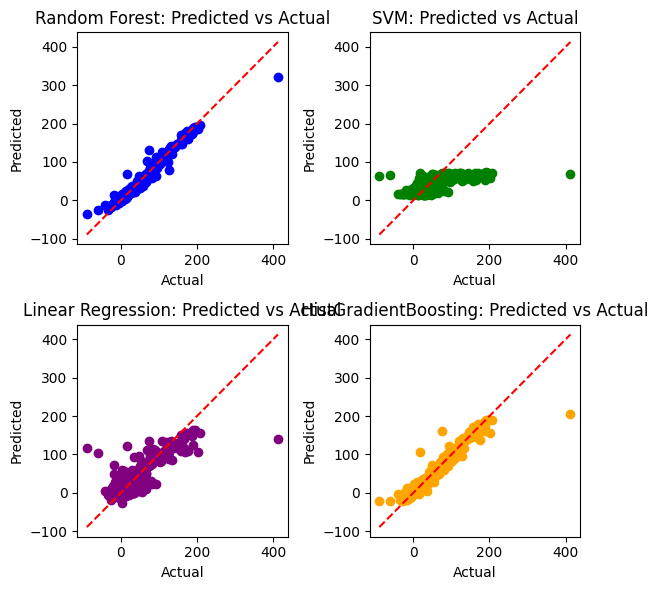

In [12]:
net_rdn = ec_data_copy[['NEE (CO2)', 'GPP', 'Ecosystem Respiration', 'Mean Air Temperature', 'Minimum Air Temperature', 'Maximum Air Temperature', 
                            'Total Rainfall', 'Net Radiation']]

# Step 1: Identify the rows where 'Net Radiation' is missing
missing_pe = net_rdn['Net Radiation'].isna()

# Step 2: Prepare data for training (only use rows where 'Net Radiation' is not missing)
train_data = net_rdn[~missing_pe]
X_train = train_data.drop(columns=['Net Radiation'])    # Features
y_train = train_data['Net Radiation']  # Target

# Step 3: Handle missing values (imputation)
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or other strategies
X_train_imputed = imputer.fit_transform(X_train)

# Step 4: Select the best model (Random Forest, SVM, or Linear Regression)
# Initialize the models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
svm_model = SVR(kernel='rbf')
lr_model = LinearRegression()
hgb_model = HistGradientBoostingRegressor()

# Train the models
rf_model.fit(X_train_imputed, y_train)
svm_model.fit(X_train_imputed, y_train)
lr_model.fit(X_train_imputed, y_train)
hgb_model.fit(X_train_imputed, y_train)

# Step 5: Evaluate the models and choose the best one (based on R^2 score, for example)
rf_score = rf_model.score(X_train_imputed, y_train)
svm_score = svm_model.score(X_train_imputed, y_train)
lr_score = lr_model.score(X_train_imputed, y_train)
hgb_score = hgb_model.score(X_train_imputed, y_train)

# Print the scores
print(f"Random Forest R^2: {rf_score}")
print(f"SVM R^2: {svm_score}")
print(f"Linear Regression R^2: {lr_score}")
print(f"HistGradientBoosting R^2: {hgb_score}")

# Choose the model with the highest R^2 score
best_model = None
best_score = -np.inf

if rf_score > best_score:
    best_model = rf_model
    best_score = rf_score
elif svm_score > best_score:
    best_model = svm_model
    best_score = svm_score
elif lr_score > best_score:
    best_model = lr_model
    best_score = lr_score
else:
    best_model = hgb_model
    best_score = hgb_score

print(f"Best model: {best_model}")

# Step 6: Use the best model to predict the missing 'Net Radiation' values
# Impute the missing rows
X_missing = net_rdn[missing_pe].drop(columns=['Net Radiation'])  # Features for missing 'Net Radiation' rows
X_missing_imputed = imputer.transform(X_missing)  # Apply the same imputation transformation

# Predict missing 'Net Radiation' values
predicted_pe = best_model.predict(X_missing_imputed)

# Step 7: Fill the missing 'Net Radiation' values with the predictions
net_rdn.loc[missing_pe, 'Net Radiation'] = predicted_pe

# Step 8: Plot graphs to compare the models' performance

# Make predictions with all models for comparison
rf_pred = rf_model.predict(X_train_imputed)
svm_pred = svm_model.predict(X_train_imputed)
lr_pred = lr_model.predict(X_train_imputed)
hgb_pred = hgb_model.predict(X_train_imputed)

# Plotting predicted vs actual for each model
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

# Random Forest
axs[0, 0].scatter(y_train, rf_pred, color='blue', label='Random Forest')
axs[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[0, 0].set_title('Random Forest: Predicted vs Actual')
axs[0, 0].set_xlabel('Actual')
axs[0, 0].set_ylabel('Predicted')

# SVM
axs[0, 1].scatter(y_train, svm_pred, color='green', label='SVM')
axs[0, 1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[0, 1].set_title('SVM: Predicted vs Actual')
axs[0, 1].set_xlabel('Actual')
axs[0, 1].set_ylabel('Predicted')

# Linear Regression
axs[1, 0].scatter(y_train, lr_pred, color='purple', label='Linear Regression')
axs[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[1, 0].set_title('Linear Regression: Predicted vs Actual')
axs[1, 0].set_xlabel('Actual')
axs[1, 0].set_ylabel('Predicted')

# HistGradientBoosting
axs[1, 1].scatter(y_train, hgb_pred, color='orange', label='HistGradientBoosting')
axs[1, 1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
axs[1, 1].set_title('HistGradientBoosting: Predicted vs Actual')
axs[1, 1].set_xlabel('Actual')
axs[1, 1].set_ylabel('Predicted')

plt.tight_layout()
plt.show()

# creating pe data for merging to the original merged dataset
mst_data = net_rdn[['Net Radiation']]
mst_data = mst_data
mst_data6 = mst_data.rename(columns={'Net Radiation': 'net_rdn'})
merged_net_rdn_df = pd.merge(net_rdn, mst_data6, left_index=True, right_index=True)

In [13]:
merged_net_rdn_df

,NEE (CO2),GPP,Ecosystem Respiration,Mean Air Temperature,Minimum Air Temperature,Maximum Air Temperature,Total Rainfall,Net Radiation,net_rdn
0,-0.021,0.5411,0.520,2.80,0.9,4.7,0.0,15.4500,15.4500
1,0.012,0.4838,0.496,1.55,-1.1,4.2,0.0,-26.4400,-26.4400
2,0.066,0.5573,0.623,7.35,3.7,11.0,10.2,2.8500,2.8500
3,0.163,0.4851,0.648,8.20,6.6,9.8,3.7,-0.8800,-0.8800
4,0.257,0.3879,0.645,7.75,5.2,10.3,3.9,22.3315,22.3315
...,...,...,...,...,...,...,...,...,...
360,-0.352,1.0520,0.700,6.25,3.1,9.4,23.8,-3.7300,-3.7300
361,-1.373,2.0833,0.711,5.70,3.3,8.1,9.5,-6.6900,-6.6900
362,-2.066,2.7445,0.678,3.30,1.1,5.5,2.6,-17.8800,-17.8800
363,-1.966,2.6447,0.679,3.75,0.7,6.8,25.5,-1.6100,-1.6100


In [16]:
print(merged_df.columns.tolist())

['index', 'Date', 'NEE (CO2)', 'GPP', 'Ecosystem Respiration', 'Mean Air Temperature', 'Minimum Air Temperature', 'Maximum Air Temperature', 'Total Rainfall', 'Total Incoming shortwave radiaiton (global radiaiton)', 'Mean Wind Speed', 'Vapour Pressure deficit', 'Mean Soil Temperature (4 cm)', 'Minimum Soil Temperature (4 cm)', 'Maximum Soil Temperature (4 cm)', 'Mean Relative Humidity', 'Mean PPFD', 'Net Radiation']


In [17]:
# Assuming df1, df2, df3, df4, df5, df6, and df7 are your dataframes
dataframes = [ec_data, mst_data1, mst_data2, mst_data3, mst_data4, mst_data5, mst_data6]

# Merge all dataframes on their indices
merged_df = dataframes[0]
for df in dataframes[1:]:
    merged_df = pd.merge(merged_df, df, left_index=True, right_index=True, how='outer')
    
# Columns to drop
columns_to_drop = ['Mean Soil Temperature (4 cm)', 'Minimum Soil Temperature (4 cm)', 'Maximum Soil Temperature (4 cm)',
                  'Mean Relative Humidity', 'Mean PPFD','Net Radiation']

# Drop the columns
merged_df = merged_df.drop(columns=columns_to_drop)

, , , , , 
# Dictionary to rename columns
rename_dict = {
    'mean_soil_t_4cm': 'Mean Soil Temperature (4 cm)',
    'min_soil_t_4cm': 'Minimum Soil Temperature (4 cm)',
    'max_soil_t_4cm': 'Maximum Soil Temperature (4 cm)',
    'mean_rh_t_4cm' : 'Mean Relative Humidity',
    'mean_ppfd' : 'Mean PPFD',
    'net_rdn' : 'Net Radiation'
}

# Rename the columns
merged_df = merged_df.rename(columns=rename_dict)
merged_df.reset_index(inplace=True)
merged_df.isnull().sum()
# Export the merged DataFrame to an Excel file
output_file = '2003_data_gapfilled.xlsx'
merged_df.to_excel(output_file, index=False)